In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from numpy import cov
import xarray as xr
import scipy.stats as stats
import math
from scipy.stats import linregress
import numpy.polynomial.polynomial as poly
from sklearn.linear_model import LinearRegression
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
import cartopy.io.img_tiles as cimgt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import cartopy.io.img_tiles as cimgt
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy import config
from matplotlib.transforms import offset_copy
%matplotlib inline
import cmocean
import glob
from scipy.io import netcdf_file as netcdf
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from shapely import geometry
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy import integrate
import scipy as sci
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from scipy.stats import kde
from scipy import signal
import metpy.calc as mpc
import matplotlib.pylab as pl
from metpy.units import units
import pymannkendall as mk

In [2]:
plt.rcParams.update({'font.size': 7})
plt.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [4]:
ymax = 4.2
tmax = 6
# parameters from simulations
omega = 1.41e-4 #tidal frequency
T = 2*np.pi/omega 
nu = 2.0e-6 #molecular viscosity (m^2 s^-1)
Pr = 14 #Prandtl number (dimensionles)
L = 3.35e5 # Latent heat of melting (units)
cp = 4.184e3 # Heat capacity of the ocean (units)
sy = 365*24*3600
rho0 = 1030 #kg/m^{-3}
Sc = 1500
Rc = 0.2
Xi = 0.052
alpha = 3.8e-5
beta = 7.8e-4
corio = 1.37e-4
gravity = 9.8
vonk = 0.41
kT = 1.4e-7 #m^2/s Thermal Diffusivity
kS = 1.3e-9 #m^2/s Salt Diffusivity

In [5]:
def cycle_average_1d(var, time, omega, start_cycle, end_cycle, dt):
    import numpy as np
    
    T = 2*np.pi/omega
    NT = int(np.floor(T/dt))
    #print(NT)
    t_cycle = np.linspace(0, T, NT)
    
    if np.floor(time[-2]/T)<end_cycle:
        print('record not', end_cycle, ' cycles long!!')
        return
    
    var_cycle = np.zeros(len(t_cycle))
    
    for ii in range(start_cycle,end_cycle):
        ttmp = time - ii*T
        tmp = np.interp(t_cycle, ttmp, var)
        var_cycle = var_cycle+tmp
        
    var_cycle = var_cycle/(end_cycle-start_cycle)
    return t_cycle, var_cycle

In [6]:
def cycle_average_2d(var, time, y, omega, start_cycle, end_cycle, dt):
    import numpy as np
    
    T = 2*np.pi/omega
    NT = int(np.floor(T/dt))
    print(NT)
    t_cycle = np.linspace(0, T, NT)
    
    if np.floor(time[-2]/T)<end_cycle:
        print('record not', end_cycle, ' cycles long!!')
        return
    
    var_cycle = np.zeros((len(t_cycle), len(y)))
    
    for ii in range(start_cycle,end_cycle):
        ttmp = time - ii*T
        for jj in range(len(y)):
            tmp = np.interp(t_cycle, ttmp, var[:,jj])
            var_cycle[:,jj] = var_cycle[:,jj]+tmp
        
    var_cycle = var_cycle/(end_cycle-start_cycle)
    return t_cycle, var_cycle

In [7]:
se_df = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes-ekman/ISOBL_model_output.nc')
se_ds = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes-ekman/mean_prof_stat.nc')

s_df = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes/ISOBL_model_output.nc')
s_ds = xr.open_dataset('C:/Users/bajus/Downloads/tidal_melting/tidal_melting/data/stokes/mean_prof_stat.nc')

In [8]:
%store -r s_u_star
%store -r se_u_star

In [9]:
%store -r s_ustar
%store -r se_ustar

In [10]:
s_speed = (s_df['U']**2 + s_df['W']**2)**(1/2)
se_speed = (se_df['U']**2 + se_df['W']**2)**(1/2)

In [11]:
s_speed[:,:].sel(y=5,method='nearest').mean('t')

C:\Users\bajus\anaconda3\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


<xarray.DataArray ()>
array(0.01765391)
Coordinates:
    y        float64 4.985

In [12]:
se_speed[:,-1].mean('t')

<xarray.DataArray ()>
array(0.01776866)
Coordinates:
    y        float64 10.03

In [13]:
se_u_1cyc = cycle_average_2d(se_df['U'], se_df['t'], se_speed['y'], omega, 3, 6, 100)
s_u_1cyc = cycle_average_2d(s_df['U'], s_df['t'], s_speed['y'], omega, 3, 6, 100)

445
445


In [14]:
se_speed_1cyc = cycle_average_2d(se_speed, se_df['t'], se_speed['y'], omega, 3, 6, 100)
s_speed_1cyc = cycle_average_2d(s_speed, s_df['t'], s_speed['y'], omega, 3, 6, 100)

445
445


In [15]:
se_u_star_1cyc = cycle_average_2d(se_u_star, se_df['t'], se_u_star['y'], omega, 3, 6, 100)
s_u_star_1cyc = cycle_average_2d(s_u_star, s_df['t'], s_u_star['y'], omega, 3, 6, 100)

445
445


In [16]:
se_ustar_1cyc = cycle_average_1d(se_ustar, se_df['t'], omega, 3, 6, 100)
s_ustar_1cyc = cycle_average_1d(s_ustar, s_df['t'], omega, 3, 6, 100)

In [17]:
(se_ustar_1cyc[0]/T)*360

array([  0.        ,   0.81081081,   1.62162162,   2.43243243,
         3.24324324,   4.05405405,   4.86486486,   5.67567568,
         6.48648649,   7.2972973 ,   8.10810811,   8.91891892,
         9.72972973,  10.54054054,  11.35135135,  12.16216216,
        12.97297297,  13.78378378,  14.59459459,  15.40540541,
        16.21621622,  17.02702703,  17.83783784,  18.64864865,
        19.45945946,  20.27027027,  21.08108108,  21.89189189,
        22.7027027 ,  23.51351351,  24.32432432,  25.13513514,
        25.94594595,  26.75675676,  27.56756757,  28.37837838,
        29.18918919,  30.        ,  30.81081081,  31.62162162,
        32.43243243,  33.24324324,  34.05405405,  34.86486486,
        35.67567568,  36.48648649,  37.2972973 ,  38.10810811,
        38.91891892,  39.72972973,  40.54054054,  41.35135135,
        42.16216216,  42.97297297,  43.78378378,  44.59459459,
        45.40540541,  46.21621622,  47.02702703,  47.83783784,
        48.64864865,  49.45945946,  50.27027027,  51.08

In [18]:
se_ustar_1cyc[1].shape

(445,)

In [19]:
s_speed_1cyc[1].shape

(445, 430)

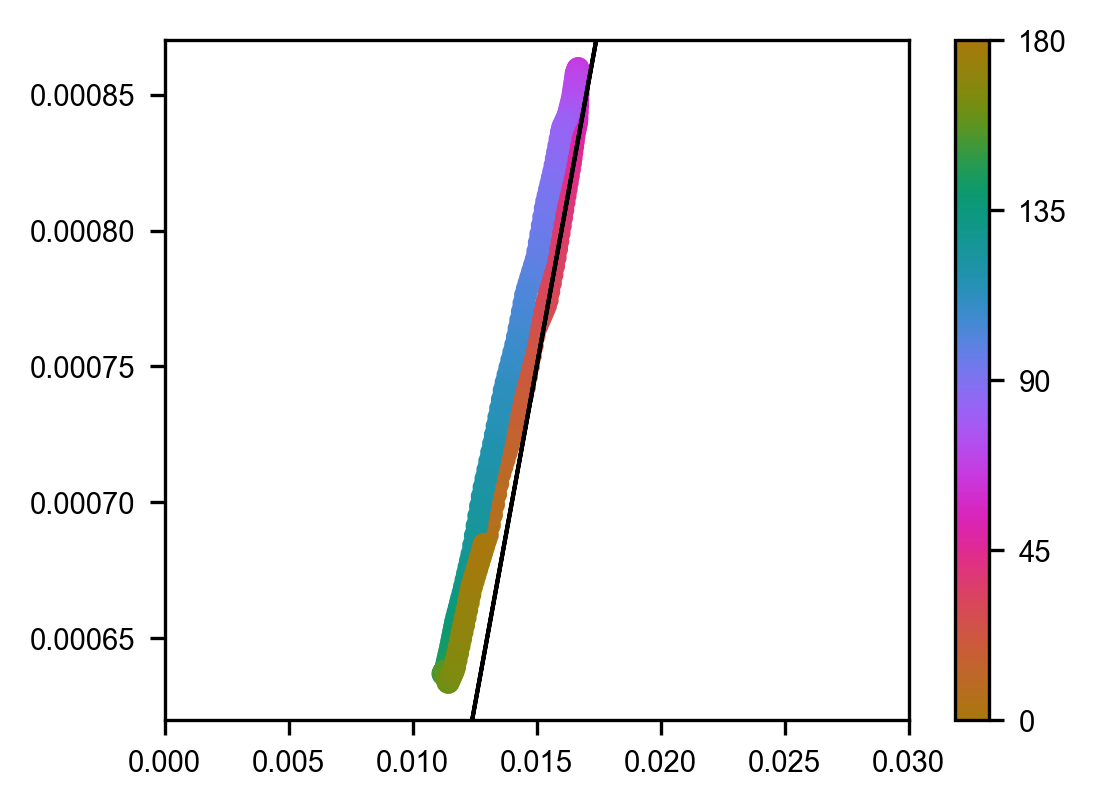

In [20]:
fig = plt.figure(figsize=(4,3))

CS = plt.scatter(se_speed_1cyc[1][:223,150],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o',zorder=-2)
plt.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=1,zorder=-1)

plt.xlim(0,0.03)
plt.ylim(0.00062,0.00087)

plt.colorbar(CS,ticks=[0,45,90,135,180])

plt.show()

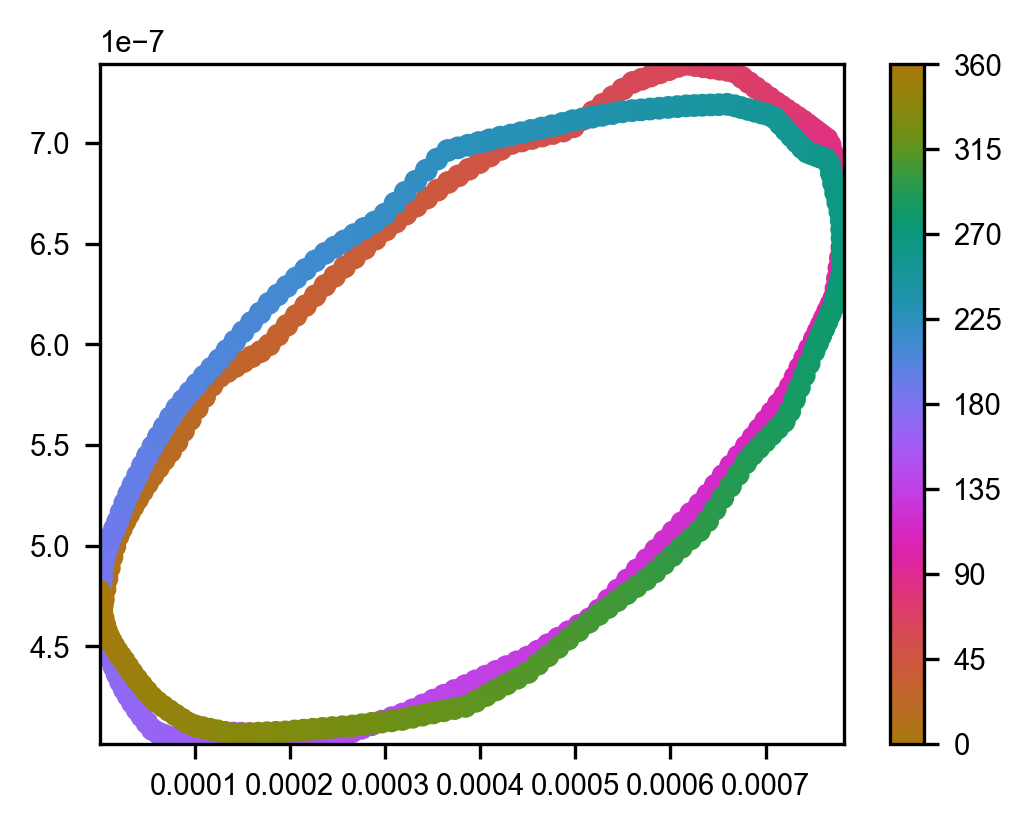

In [21]:
fig = plt.figure(figsize=(4,3))

CS = plt.scatter(se_speed_1cyc[1][:,-2]**2,se_ustar_1cyc[1]**2,c=(se_ustar_1cyc[0]/T)*360,cmap='cmo.phase',s=20,marker='o',zorder=-2)
#plt.plot(se_speed_1cyc[1][:,10],(1.0673968068850035)*(se_speed_1cyc[1][:,10]),color='black',linewidth=1,zorder=-1)

#plt.xlim(0,0.03)
#plt.ylim(0.00062,0.00087)

plt.colorbar(CS,ticks=[0,45,90,135,180,225,270,315,360])

plt.show()

In [22]:
s_df['y'][174]

<xarray.DataArray 'y' ()>
array(0.74997275)
Coordinates:
    y        float64 0.75

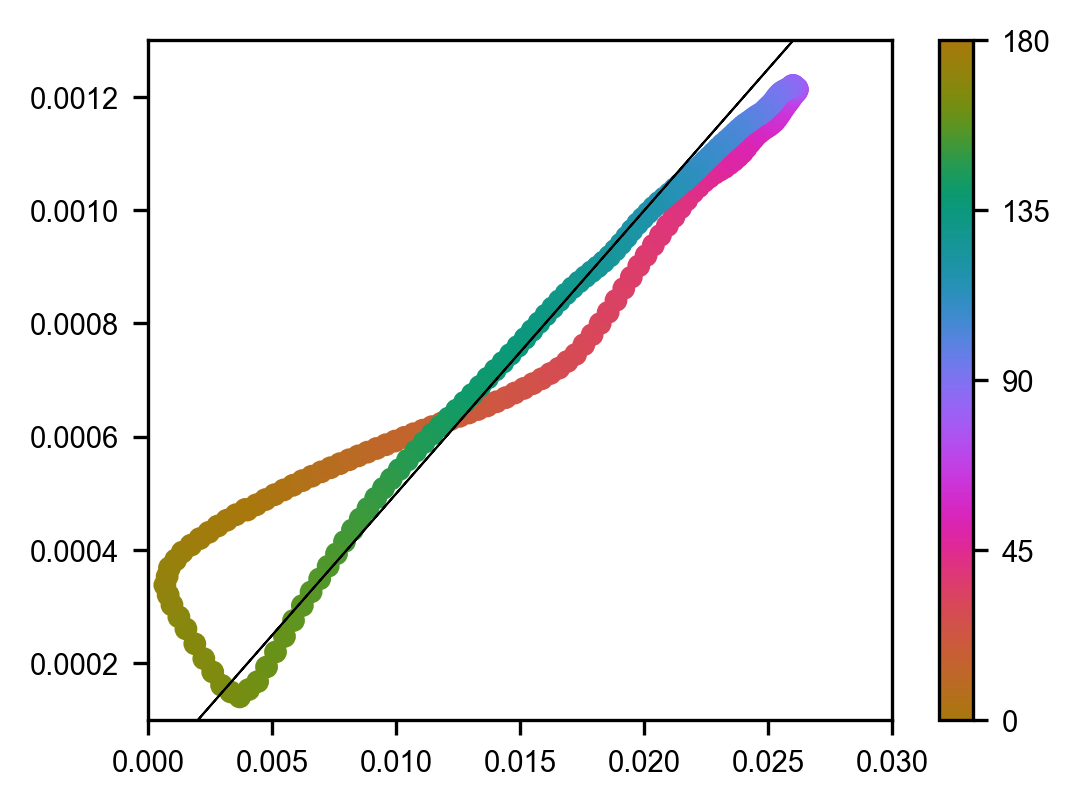

In [23]:
fig = plt.figure(figsize=(4,3))

CS = plt.scatter(s_speed_1cyc[1][:223,174],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
plt.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

plt.xlim(0,0.03)
plt.ylim(0.0001,0.0013)

plt.colorbar(CS,ticks=[0,45,90,135,180])

plt.show()

In [24]:
se_u_star[:,400]

<xarray.DataArray (t: 462)>
array([4.96266946e-16, 3.52259452e-10, 6.12525080e-10, 1.62934351e-09,
       2.37951749e-09, 5.20808829e-09, 8.36745782e-09, 1.22086724e-08,
       2.42233961e-08, 3.33763407e-08, 4.81468449e-08, 7.40268490e-08,
       1.01085278e-07, 1.33800384e-07, 1.96692615e-07, 2.52544015e-07,
       3.19628113e-07, 4.54658560e-07, 4.85240995e-07, 6.73027458e-07,
       6.22086917e-07, 9.73251369e-07, 1.18766271e-06, 1.12533833e-06,
       1.36129785e-06, 1.66106490e-06, 1.29472921e-06, 1.22949427e-06,
       1.54107149e-06, 1.61166058e-06, 2.77740635e-06, 2.09166562e-06,
       3.74672846e-06, 4.31495658e-06, 6.60680552e-06, 1.02457456e-05,
       1.23909792e-05, 1.44203467e-05, 1.74686104e-05, 2.07353912e-05,
       2.20345770e-05, 2.29639552e-05, 2.43613647e-05, 2.48654104e-05,
       2.41172869e-05, 2.09252875e-05, 1.69886176e-05, 1.32237418e-05,
       8.50334636e-06, 1.17964854e-05, 1.63014302e-05, 1.71104321e-05,
       1.84466667e-05, 2.43963996e-05, 2.56458995e-05, 2.66111218e-05,
       3.03641928e-05, 3.10992580e-05, 2.29118414e-05, 1.85930980e-05,
       2.27700387e-05, 2.11499984e-05, 2.51005028e-05, 2.34578666e-05,
       2.50543291e-05, 2.81475397e-05, 2.34966620e-05, 2.27954170e-05,
       3.08199933e-05, 3.11472059e-05, 2.37971354e-05, 1.20006621e-05,
       1.78603299e-05, 1.52388325e-05, 1.08904237e-05, 1.19803066e-05,
       1.93854976e-05, 1.49198299e-05, 2.28534009e-05, 2.60585145e-05,
...
       1.59122865e-05, 1.64721080e-05, 1.56301086e-05, 1.13081307e-05,
       7.91011826e-06, 1.17801437e-05, 1.02300644e-05, 6.16507631e-06,
       1.01411722e-05, 8.18405914e-06, 5.15161374e-06, 5.89780354e-06,
       7.12367718e-06, 1.01045815e-05, 8.00731293e-06, 1.15106437e-05,
       1.19891885e-05, 1.32450845e-05, 1.31614491e-05, 1.59959319e-05,
       1.76029680e-05, 1.76472851e-05, 1.67553582e-05, 1.52886027e-05,
       1.51149152e-05, 1.72439237e-05, 1.69500339e-05, 1.19807691e-05,
       3.94309997e-06, 9.72183174e-06, 1.18763255e-05, 1.39898628e-05,
       1.22544090e-05, 1.57566134e-05, 1.95161792e-05, 1.84413437e-05,
       1.70986379e-05, 1.86045512e-05, 2.01601961e-05, 1.70931455e-05,
       1.24211594e-05, 1.01423326e-05, 1.02553215e-05, 4.52009546e-06,
       8.93525429e-06, 6.64632639e-06, 4.76989407e-06, 4.98889525e-06,
       5.57555212e-06, 1.59650827e-06, 8.10990705e-06, 1.09159731e-05,
       1.16292145e-05, 9.56370894e-06, 1.34901458e-05, 1.47403874e-05,
       1.48064750e-05, 1.73887664e-05, 1.97056298e-05, 1.92019621e-05,
       2.16761291e-05, 1.98757334e-05, 1.98784393e-05, 2.12678437e-05,
       8.25708477e-06, 1.32751862e-05, 1.87967359e-05, 8.95417619e-06,
       8.92123736e-06, 1.89461578e-05, 1.58322179e-05, 1.19979497e-05,
       1.43403154e-05, 1.91094916e-05, 1.94939265e-05, 1.83551526e-05,
       2.04017723e-05, 1.99777093e-05])
Coordinates:
    y        float64 8.018
  * t        (t) float64 3.298 568.0 1.168e+03 ... 2.764e+05 2.769e+05 2.776e+05

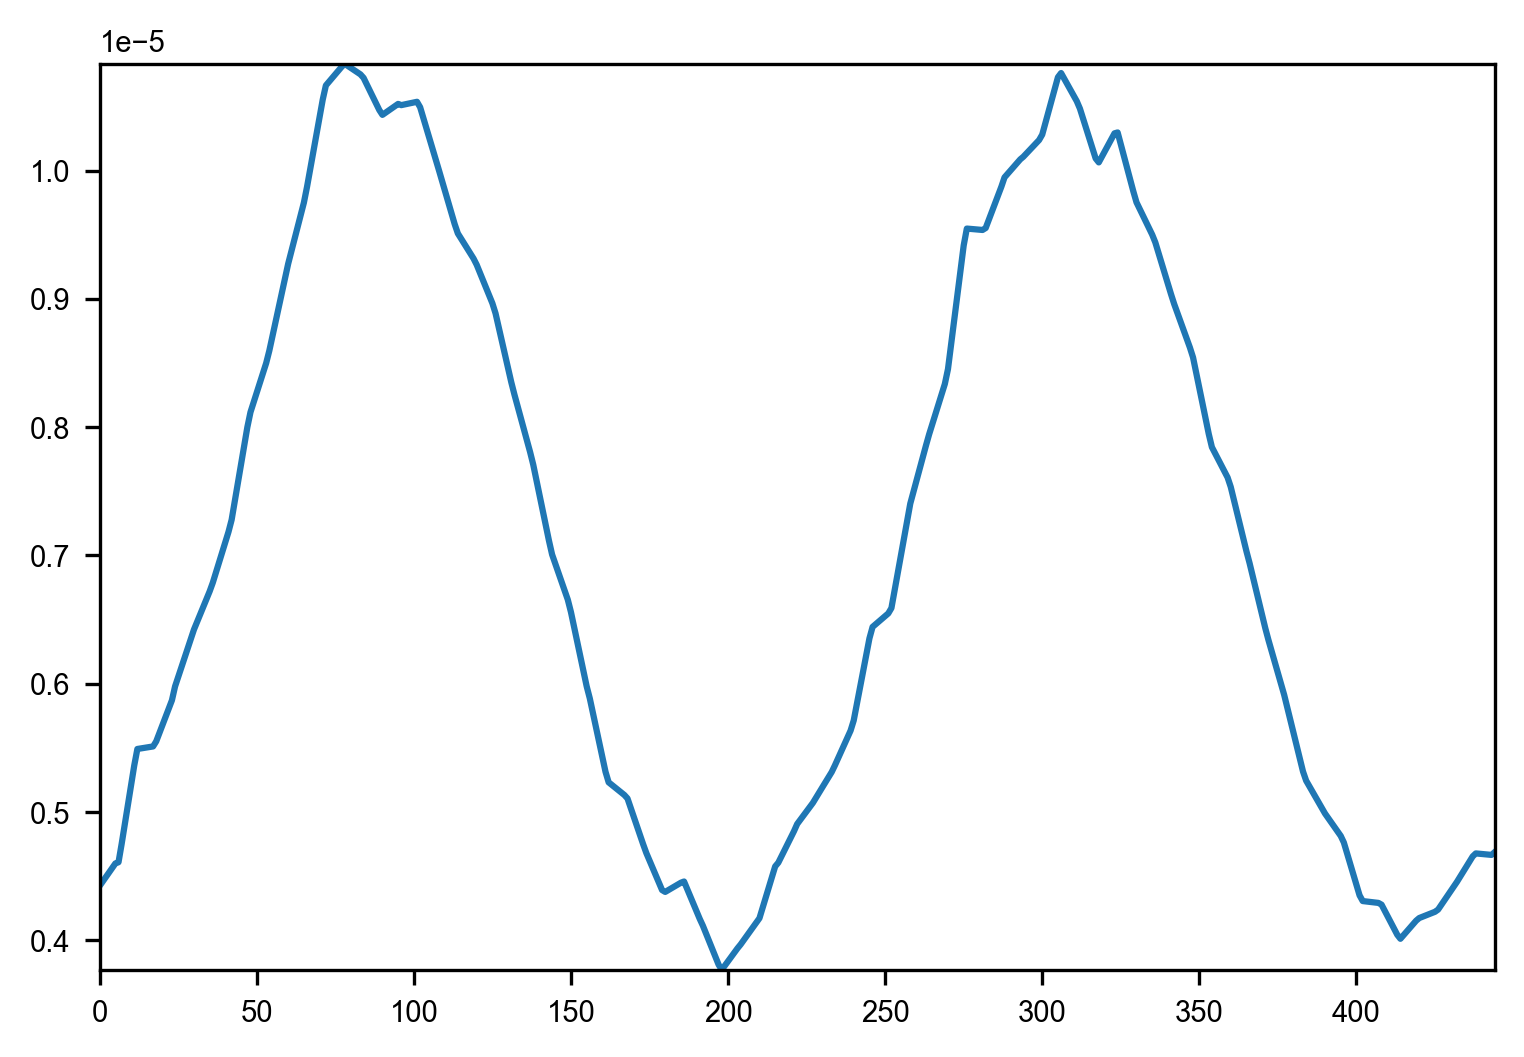

In [25]:
plt.plot(se_u_star_1cyc[1][:,1])

In [26]:
((s_ustar_1cyc[0]/T)*360)[:223]

array([  0.        ,   0.81081081,   1.62162162,   2.43243243,
         3.24324324,   4.05405405,   4.86486486,   5.67567568,
         6.48648649,   7.2972973 ,   8.10810811,   8.91891892,
         9.72972973,  10.54054054,  11.35135135,  12.16216216,
        12.97297297,  13.78378378,  14.59459459,  15.40540541,
        16.21621622,  17.02702703,  17.83783784,  18.64864865,
        19.45945946,  20.27027027,  21.08108108,  21.89189189,
        22.7027027 ,  23.51351351,  24.32432432,  25.13513514,
        25.94594595,  26.75675676,  27.56756757,  28.37837838,
        29.18918919,  30.        ,  30.81081081,  31.62162162,
        32.43243243,  33.24324324,  34.05405405,  34.86486486,
        35.67567568,  36.48648649,  37.2972973 ,  38.10810811,
        38.91891892,  39.72972973,  40.54054054,  41.35135135,
        42.16216216,  42.97297297,  43.78378378,  44.59459459,
        45.40540541,  46.21621622,  47.02702703,  47.83783784,
        48.64864865,  49.45945946,  50.27027027,  51.08

In [27]:
1.25-s_df['y'][216]

<xarray.DataArray 'y' ()>
array(-0.00250801)
Coordinates:
    y        float64 1.253

In [28]:
s_speed_1cyc[1][:223,1]

array([1.63289278e-04, 1.69616081e-04, 1.75910664e-04, 1.82062804e-04,
       1.88166340e-04, 1.94219191e-04, 2.00272042e-04, 2.06113884e-04,
       2.11900052e-04, 2.17582690e-04, 2.23225006e-04, 2.28735091e-04,
       2.34245176e-04, 2.39615018e-04, 2.44952601e-04, 2.50455788e-04,
       2.55980619e-04, 2.61526109e-04, 2.67071600e-04, 2.72575637e-04,
       2.78069432e-04, 2.83533522e-04, 2.88997612e-04, 2.94374767e-04,
       2.99746431e-04, 3.05495797e-04, 3.11308439e-04, 3.18307681e-04,
       3.25333791e-04, 3.33274468e-04, 3.41239120e-04, 3.49491982e-04,
       3.58063714e-04, 3.67731485e-04, 3.77399256e-04, 3.90057872e-04,
       4.03551761e-04, 4.22514819e-04, 4.42017909e-04, 4.64767967e-04,
       4.87689382e-04, 5.13031619e-04, 5.38365614e-04, 5.63610696e-04,
       5.88783615e-04, 6.12813156e-04, 6.36842696e-04, 6.60438944e-04,
       6.83925927e-04, 7.06262861e-04, 7.28599795e-04, 7.48892469e-04,
       7.68226519e-04, 7.82466152e-04, 7.96705785e-04, 8.07940172e-04,
      

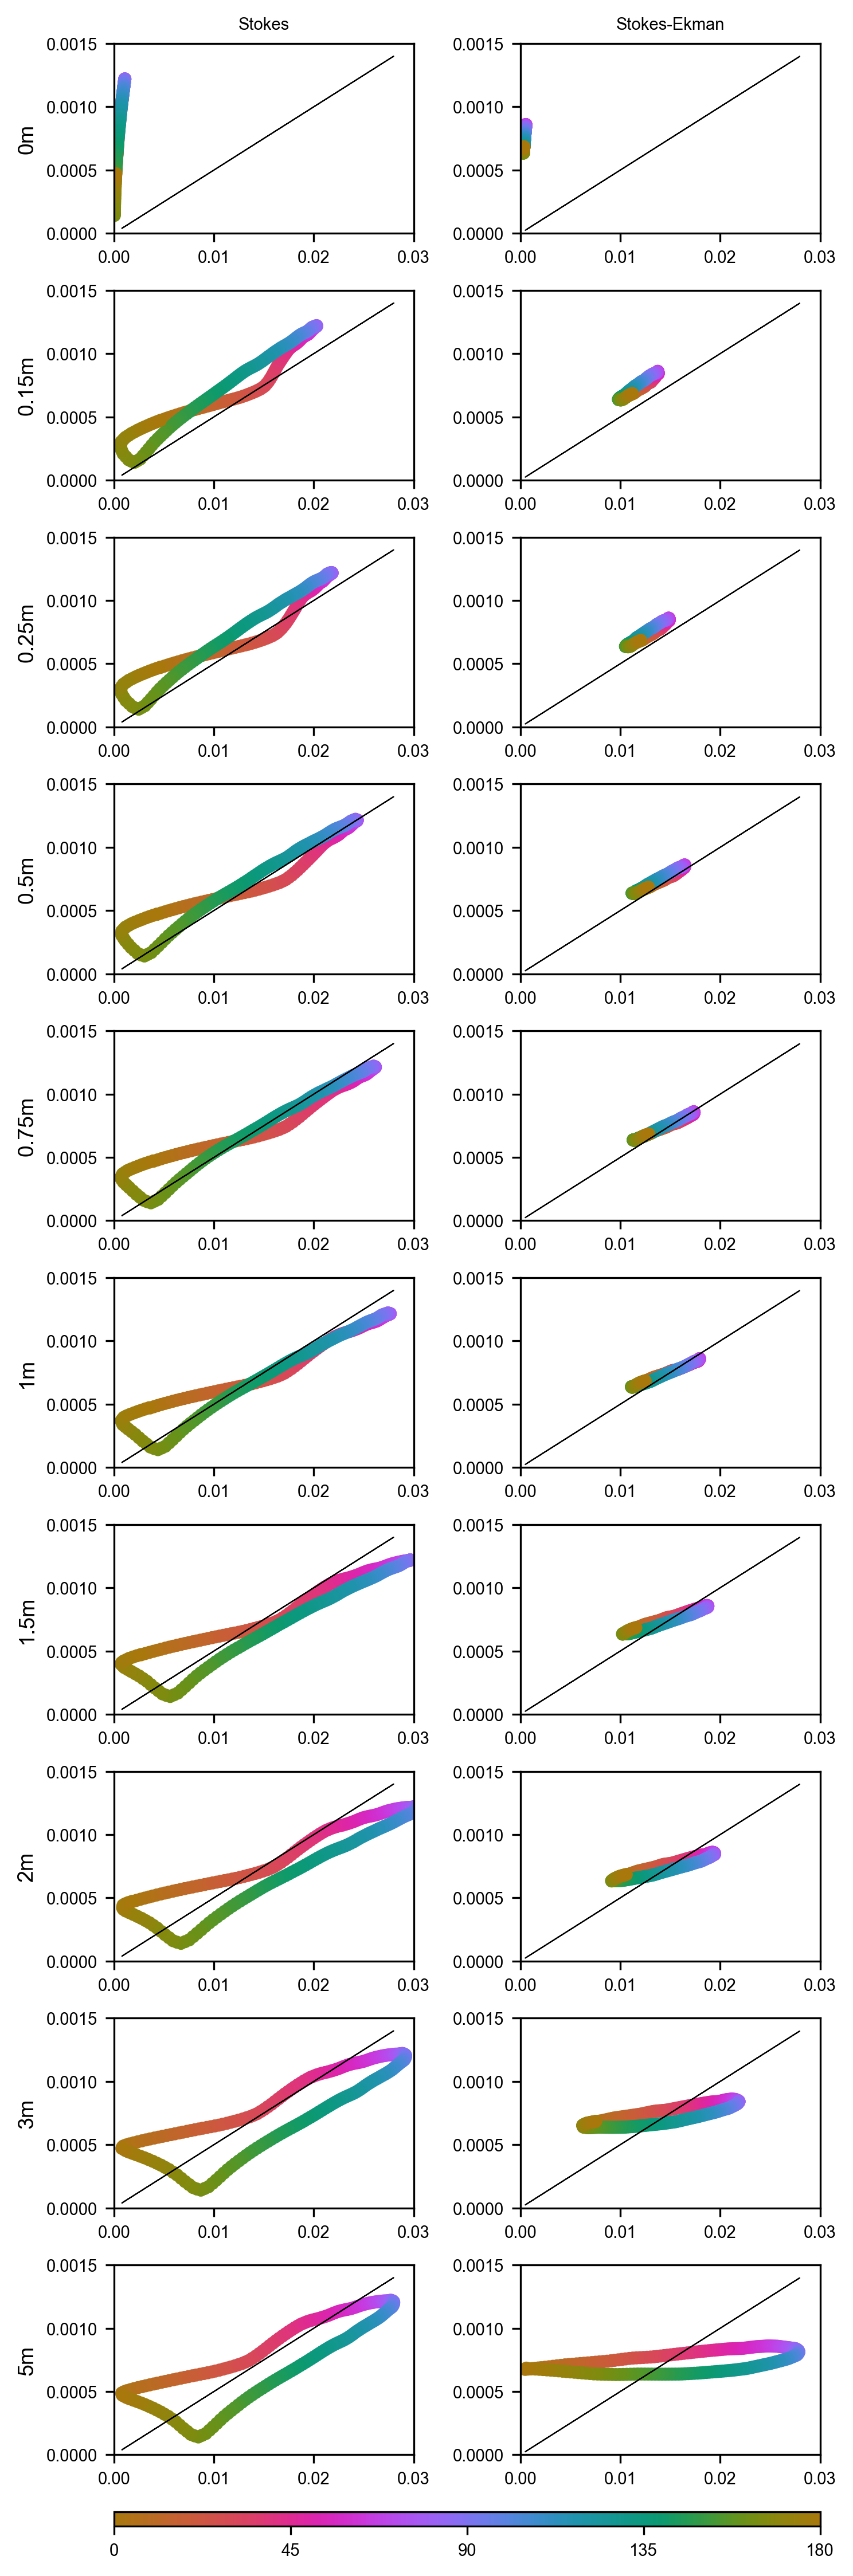

In [29]:
fig = plt.figure(figsize=(5,15))


gs = fig.add_gridspec(11,2,height_ratios=[20,20,20,20,20,20,20,20,20,20,1.5])

ax1 = fig.add_subplot(gs[0,0])
ax11 = fig.add_subplot(gs[0,1])

ax2 = fig.add_subplot(gs[1,0])
ax21 = fig.add_subplot(gs[1,1])

ax3 = fig.add_subplot(gs[2,0])
ax31 = fig.add_subplot(gs[2,1])

ax4 = fig.add_subplot(gs[3,0])
ax41 = fig.add_subplot(gs[3,1])

ax5 = fig.add_subplot(gs[4,0])
ax51 = fig.add_subplot(gs[4,1])

ax6 = fig.add_subplot(gs[5,0])
ax61 = fig.add_subplot(gs[5,1])

ax7 = fig.add_subplot(gs[6,0])
ax71 = fig.add_subplot(gs[6,1])

ax8 = fig.add_subplot(gs[7,0])
ax81 = fig.add_subplot(gs[7,1])

ax9 = fig.add_subplot(gs[8,0])
ax91 = fig.add_subplot(gs[8,1])

ax10 = fig.add_subplot(gs[9,0])
ax101 = fig.add_subplot(gs[9,1])

cax = fig.add_subplot(gs[10,:])


CS1 = ax1.scatter(s_speed_1cyc[1][:223,1],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax1.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax1.set_xlim(0,0.03)
#ax1.set_ylim(0.0001,0.0013)

#plt.colorbar(CS1,ax=ax1,ticks=[0,45,90,135,180])


CS11 = ax11.scatter(se_speed_1cyc[1][:223,1],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax11.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax11.set_xlim(0,0.03)
#ax11.set_ylim(0.0001,0.0013)

#plt.colorbar(CS11,ax=ax11,ticks=[0,45,90,135,180])




CS2 = ax2.scatter(s_speed_1cyc[1][:223,69],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax2.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax2.set_xlim(0,0.03)
#ax2.set_ylim(0.0001,0.0013)

#plt.colorbar(CS2,ax=ax2,ticks=[0,45,90,135,180])


CS21 = ax21.scatter(se_speed_1cyc[1][:223,69],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax21.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax21.set_xlim(0,0.03)
#ax21.set_ylim(0.0001,0.0013)

#plt.colorbar(CS21,ax=ax21,ticks=[0,45,90,135,180])




CS3 = ax3.scatter(s_speed_1cyc[1][:223,97],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax3.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax3.set_xlim(0,0.03)
#ax3.set_ylim(0.0001,0.0013)

#plt.colorbar(CS3,ax=ax3,ticks=[0,45,90,135,180])


CS31 = ax31.scatter(se_speed_1cyc[1][:223,97],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax31.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax31.set_xlim(0,0.03)
#ax31.set_ylim(0.0001,0.0013)

#plt.colorbar(CS31,ax=ax31,ticks=[0,45,90,135,180])




CS4 = ax4.scatter(s_speed_1cyc[1][:223,143],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax4.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax4.set_xlim(0,0.03)
#ax4.set_ylim(0.0001,0.0013)

#plt.colorbar(CS4,ax=ax4,ticks=[0,45,90,135,180])


CS41 = ax41.scatter(se_speed_1cyc[1][:223,143],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax41.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax41.set_xlim(0,0.03)
#ax41.set_ylim(0.0001,0.0013)

#plt.colorbar(CS41,ax=ax41,ticks=[0,45,90,135,180])




CS5 = ax5.scatter(s_speed_1cyc[1][:223,174],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax5.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax5.set_xlim(0,0.03)
#ax5.set_ylim(0.0001,0.0013)

#plt.colorbar(CS5,ax=ax5,ticks=[0,45,90,135,180])


CS51 = ax51.scatter(se_speed_1cyc[1][:223,174],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax51.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax51.set_xlim(0,0.03)
#ax51.set_ylim(0.0001,0.0013)

#plt.colorbar(CS51,ax=ax51,ticks=[0,45,90,135,180])




CS6 = ax6.scatter(s_speed_1cyc[1][:223,197],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax6.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax6.set_xlim(0,0.03)
#ax6.set_ylim(0.0001,0.0013)

#plt.colorbar(CS6,ax=ax6,ticks=[0,45,90,135,180])


CS61 = ax61.scatter(se_speed_1cyc[1][:223,197],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax61.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax61.set_xlim(0,0.03)
#ax61.set_ylim(0.0001,0.0013)

#plt.colorbar(CS61,ax=ax61,ticks=[0,45,90,135,180])




CS7 = ax7.scatter(s_speed_1cyc[1][:223,232],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax7.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax7.set_xlim(0,0.03)
#ax7.set_ylim(0.0001,0.0013)

#plt.colorbar(CS7,ax=ax7,ticks=[0,45,90,135,180])


CS71 = ax71.scatter(se_speed_1cyc[1][:223,232],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax71.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax71.set_xlim(0,0.03)
#ax71.set_ylim(0.0001,0.0013)

#plt.colorbar(CS71,ax=ax71,ticks=[0,45,90,135,180])




CS8 = ax8.scatter(s_speed_1cyc[1][:223,257],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax8.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax8.set_xlim(0,0.03)
#ax8.set_ylim(0.0001,0.0013)

#plt.colorbar(CS8,ax=ax8,ticks=[0,45,90,135,180])


CS81 = ax81.scatter(se_speed_1cyc[1][:223,257],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax81.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax81.set_xlim(0,0.03)
#ax81.set_ylim(0.0001,0.0013)

#plt.colorbar(CS81,ax=ax81,ticks=[0,45,90,135,180])




CS9 = ax9.scatter(s_speed_1cyc[1][:223,295],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax9.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax9.set_xlim(0,0.03)
#ax9.set_ylim(0.0001,0.0013)

#plt.colorbar(CS9,ax=ax9,ticks=[0,45,90,135,180])


CS91 = ax91.scatter(se_speed_1cyc[1][:223,295],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax91.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax91.set_xlim(0,0.03)
#ax91.set_ylim(0.0001,0.0013)

#plt.colorbar(CS91,ax=ax91,ticks=[0,45,90,135,180])




CS10 = ax10.scatter(s_speed_1cyc[1][:223,346],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax10.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax10.set_xlim(0,0.03)
#ax10.set_ylim(0.0001,0.0013)

#plt.colorbar(CS10,ax=ax10,ticks=[0,45,90,135,180])


CS101 = ax101.scatter(se_speed_1cyc[1][:223,346],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=20,marker='o')
ax101.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax101.set_xlim(0,0.03)
#ax101.set_ylim(0.0001,0.0013)

#plt.colorbar(CS101,ax=ax101,ticks=[0,45,90,135,180])




ax1.set_xlim(0,0.03)
ax2.set_xlim(0,0.03)
ax3.set_xlim(0,0.03)
ax4.set_xlim(0,0.03)
ax5.set_xlim(0,0.03)
ax6.set_xlim(0,0.03)
ax7.set_xlim(0,0.03)
ax8.set_xlim(0,0.03)
ax9.set_xlim(0,0.03)
ax10.set_xlim(0,0.03)

ax1.set_ylim(0,0.0015)
ax2.set_ylim(0,0.0015)
ax3.set_ylim(0,0.0015)
ax4.set_ylim(0,0.0015)
ax5.set_ylim(0,0.0015)
ax6.set_ylim(0,0.0015)
ax7.set_ylim(0,0.0015)
ax8.set_ylim(0,0.0015)
ax9.set_ylim(0,0.0015)
ax10.set_ylim(0,0.0015)



ax11.set_xlim(0,0.03)
ax21.set_xlim(0,0.03)
ax31.set_xlim(0,0.03)
ax41.set_xlim(0,0.03)
ax51.set_xlim(0,0.03)
ax61.set_xlim(0,0.03)
ax71.set_xlim(0,0.03)
ax81.set_xlim(0,0.03)
ax91.set_xlim(0,0.03)
ax101.set_xlim(0,0.03)

ax11.set_ylim(0,0.0015)
ax21.set_ylim(0,0.0015)
ax31.set_ylim(0,0.0015)
ax41.set_ylim(0,0.0015)
ax51.set_ylim(0,0.0015)
ax61.set_ylim(0,0.0015)
ax71.set_ylim(0,0.0015)
ax81.set_ylim(0,0.0015)
ax91.set_ylim(0,0.0015)
ax101.set_ylim(0,0.0015)



ax1.set_ylabel('0m',fontsize=9)
ax2.set_ylabel('0.15m',fontsize=9)
ax3.set_ylabel('0.25m',fontsize=9)
ax4.set_ylabel('0.5m',fontsize=9)
ax5.set_ylabel('0.75m',fontsize=9)
ax6.set_ylabel('1m',fontsize=9)
ax7.set_ylabel('1.5m',fontsize=9)
ax8.set_ylabel('2m',fontsize=9)
ax9.set_ylabel('3m',fontsize=9)
ax10.set_ylabel('5m',fontsize=9)


ax1.set_title('Stokes',fontsize=7)
ax11.set_title('Stokes-Ekman',fontsize=7)


m = plt.cm.ScalarMappable(cmap='cmo.phase')
m.set_clim(0,180)
plt.colorbar(m,cax=cax, boundaries=np.linspace(0,180,250),ticks=[0,45,90,135,180],shrink=1,orientation='horizontal')





plt.tight_layout()
plt.show()

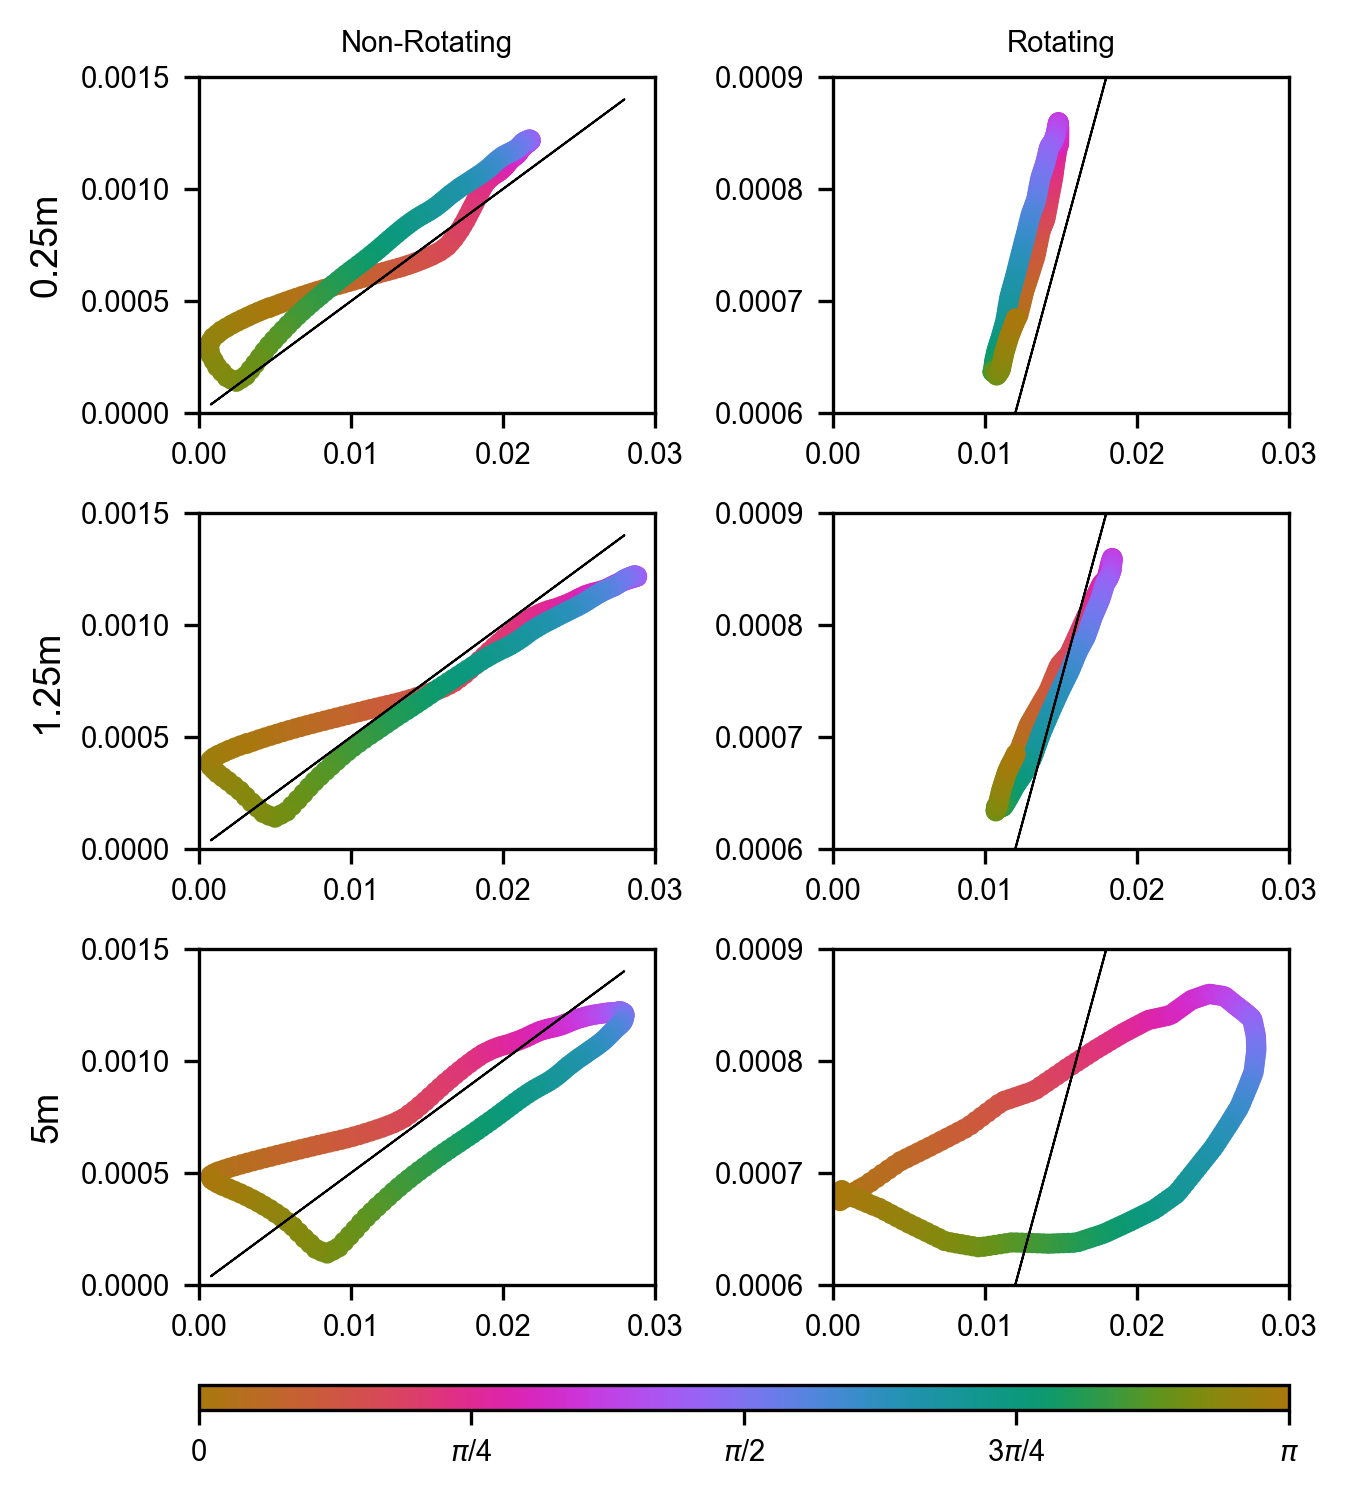

In [31]:
fig = plt.figure(figsize=(4.5,5))


gs = fig.add_gridspec(4,2,height_ratios=[20,20,20,1.5])

ax1 = fig.add_subplot(gs[0,0])
ax11 = fig.add_subplot(gs[0,1])

ax2 = fig.add_subplot(gs[1,0])
ax21 = fig.add_subplot(gs[1,1])

ax3 = fig.add_subplot(gs[2,0])
ax31 = fig.add_subplot(gs[2,1])


cax = fig.add_subplot(gs[3,:])




CS1 = ax1.scatter(s_speed_1cyc[1][:223,97],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=15,marker='o')
ax1.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax1.set_xlim(0,0.03)
#ax1.set_ylim(0.0001,0.0013)

#plt.colorbar(CS1,ax=ax1,ticks=[0,45,90,135,180])


CS11 = ax11.scatter(se_speed_1cyc[1][:223,97],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=15,marker='o')
ax11.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax11.set_xlim(0,0.03)
#ax11.set_ylim(0.0001,0.0013)

#plt.colorbar(CS11,ax=ax11,ticks=[0,45,90,135,180])




CS2 = ax2.scatter(s_speed_1cyc[1][:223,216],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=15,marker='o')
ax2.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax2.set_xlim(0,0.03)
#ax2.set_ylim(0.0001,0.0013)

#plt.colorbar(CS2,ax=ax2,ticks=[0,45,90,135,180])


CS21 = ax21.scatter(se_speed_1cyc[1][:223,216],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=15,marker='o')
ax21.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax21.set_xlim(0,0.03)
#ax21.set_ylim(0.0001,0.0013)

#plt.colorbar(CS21,ax=ax21,ticks=[0,45,90,135,180])




CS10 = ax3.scatter(s_speed_1cyc[1][:223,346],s_ustar_1cyc[1][:223],c=(s_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=15,marker='o')
ax3.plot(s_speed_1cyc[1][:223,-1],(0.05)*(s_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax3.set_xlim(0,0.03)
#ax3.set_ylim(0.0001,0.0013)

#plt.colorbar(CS3,ax=ax3,ticks=[0,45,90,135,180])


CS31 = ax31.scatter(se_speed_1cyc[1][:223,346],se_ustar_1cyc[1][:223],c=(se_ustar_1cyc[0][:223]/T)*360,cmap='cmo.phase',s=15,marker='o')
ax31.plot(se_speed_1cyc[1][:223,-1],(0.05)*(se_speed_1cyc[1][:223,-1]),color='black',linewidth=0.5)

#ax31.set_xlim(0,0.03)
#ax31.set_ylim(0.0001,0.0013)

#plt.colorbar(CS31,ax=ax31,ticks=[0,45,90,135,180])




ax1.set_xlim(0,0.03)
ax2.set_xlim(0,0.03)
ax3.set_xlim(0,0.03)

ax1.set_ylim(0,0.0015)
ax2.set_ylim(0,0.0015)
ax3.set_ylim(0,0.0015)

ax11.set_xlim(0,0.03)
ax21.set_xlim(0,0.03)
ax31.set_xlim(0,0.03)

ax11.set_ylim(0.0006,0.0009)
ax21.set_ylim(0.0006,0.0009)
ax31.set_ylim(0.0006,0.0009)

ax1.set_ylabel('0.25m',fontsize=9)
ax2.set_ylabel('1.25m',fontsize=9)
ax3.set_ylabel('5m',fontsize=9)

ax1.set_title('Non-Rotating',fontsize=7)
ax11.set_title('Rotating',fontsize=7)




m = plt.cm.ScalarMappable(cmap='cmo.phase')
m.set_clim(0,180)
cbar1 = plt.colorbar(m,cax=cax, boundaries=np.linspace(0,180,250),ticks=[0,45,90,135,180],shrink=1,orientation='horizontal')
cbar1.ax.set_xticklabels(['0','$\pi$/4','$\pi$/2','3$\pi$/4','$\pi$'])






plt.tight_layout()
plt.show()